In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys, pathlib

# project root (parent of Notebooks/) so `from Code...` works
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale
from Code.models import fit_ols 
from Code.metrics import mse, r2
from Code.models import predict_from_theta, fit_ridge, fit_ols, sweep_degree
from Code.resampling import bias_variance_from_preds, bootstrap_predictions

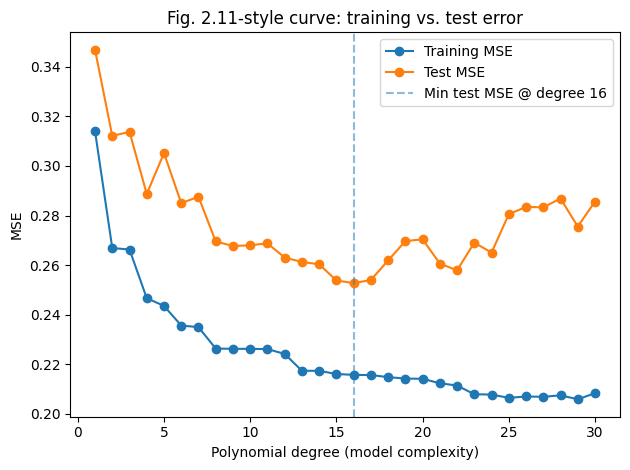

In [44]:


# ===== Fig 2.11-style: train & test MSE vs. model complexity =====
rng = np.random.default_rng(1)
x, y = make_data(n=300, noise_sd=0.5, seed=1)
deg_max = 30
X_full = build_features(x, degree=deg_max, include_bias=False)

# one fixed split, centered y as in your pipeline
split = lambda X,Y: split_and_scale(X, Y, test_size=0.3, random_state=1, center_y=True)
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

train_mse, test_mse = [], []
degrees = list(range(1, deg_max + 1))

for p in degrees:
    Xtr_p = X_tr_s[:, :p]
    Xte_p = X_te_s[:, :p]

    theta   = fit_ols(Xtr_p, y_tr_c)                     # fit on centered y
    yhat_tr = predict_from_theta(Xtr_p, theta, y_mean)   # (n,)
    yhat_te = predict_from_theta(Xte_p, theta, y_mean)   # (n,)

    # ensure targets are 1-D to match predictions
    y_tr_uncentered = (y_tr_c + y_mean).ravel()
    y_te_1d         = y_te.ravel()

    train_mse.append(metrics.mse(y_tr_uncentered, yhat_tr))
    test_mse.append(metrics.mse(y_te_1d,        yhat_te))

plt.figure()
plt.plot(degrees, train_mse, marker="o", label="Training MSE")
plt.plot(degrees, test_mse,  marker="o", label="Test MSE")
best_idx = int(np.argmin(test_mse))
plt.axvline(degrees[best_idx], linestyle="--", alpha=0.5,
            label=f"Min test MSE @ degree {degrees[best_idx]}")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("MSE")
plt.title("Fig. 2.11-style curve: training vs. test error")
plt.legend()
plt.tight_layout()


[9.591955062867552e-05, 0.00014905725574476488, 0.00021740975730818681, 0.00015309023616042028, 0.00019978153334954888, 0.00013754380108143798, 0.00017349945874525985, 0.0001478700621003761, 0.00018197497921402042, 0.00011628445296247628, 0.00014739576302313004, 0.00017437978655042232, 0.00025171629202860234, 0.0001884024581444329, 0.00030476198526559526]


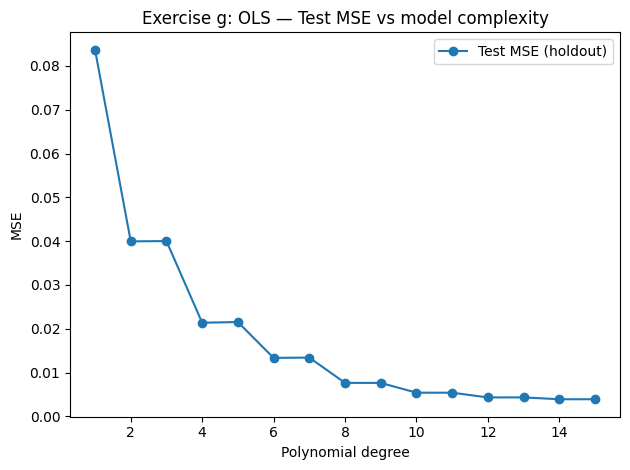

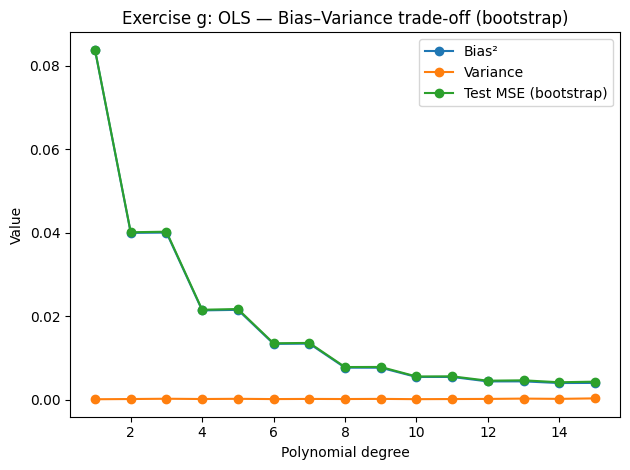

In [45]:
# ----- data & features -----
rng = np.random.default_rng(1)
x, y = make_data(n=600, noise_sd=0.05, seed=1)
deg_max = 15
X_full = build_features(x, degree=deg_max, include_bias=False)

split = lambda X,Y: split_and_scale(X, Y, test_size=0.3, random_state=1, center_y=True)

# ===== 1) OLS test MSE vs degree (one-liner helper) =====
degrees, mses, r2s, norms = sweep_degree(X_full, y, split_func=split, deg_max=deg_max)

plt.figure()
plt.plot(degrees, mses, marker="o", label="Test MSE (holdout)")
plt.xlabel("Polynomial degree"); plt.ylabel("MSE")
plt.title("Exercise g: OLS — Test MSE vs model complexity")
plt.legend(); plt.tight_layout() 

plt.savefig(fig_dir / "ols_mse_degree.png", dpi=300, bbox_inches="tight")

# ===== 2) OLS bias–variance with bootstrap =====
# Get a single train/test split once, then reuse for all degrees
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

B = 200
bias2_list, var_list, mse_te_list = [], [], []

for p in range(1, deg_max + 1):
    # Bootstrap predictions: P shape is (B, n_test)
    P = bootstrap_predictions(
        fit_fn=fit_ols,                 # closed-form OLS on centered y
        pred_fn=predict_from_theta,     # adds back y_mean
        Xtr_s=X_tr_s[:, :p],
        ytr_c=y_tr_c,
        Xte_s=X_te_s[:, :p],
        y_mean=y_mean,
        B=B, seed=1
    )
    bias2, var, mse = bias_variance_from_preds(P, y_true=y_te)
    bias2_list.append(bias2)
    var_list.append(var)
    mse_te_list.append(mse)

plt.figure()
plt.plot(range(1, deg_max+1), bias2_list, marker="o", label="Bias²")
plt.plot(range(1, deg_max+1), var_list,   marker="o", label="Variance")
plt.plot(range(1, deg_max+1), mse_te_list,marker="o", label="Test MSE (bootstrap)")
plt.xlabel("Polynomial degree"); plt.ylabel("Value")
plt.title("Exercise g: OLS — Bias–Variance trade-off (bootstrap)")
plt.legend(); plt.tight_layout()
print(var_list)

plt.savefig(fig_dir / "ols_bias_variance.png", dpi=300, bbox_inches="tight")